# Setup

In [115]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)

from src.utilities import high_points_by_position

In [120]:
raw_data = pd.read_csv("../data/processed/data_with_odds.csv")

gk_columns = ["name_player",
              "total_points_player",
              "team_player",
              "season",
              "bonus_player",
              "clean_sheets_player",
              "saves_player",
              "was_home_player",
              "last_10_games_points_player",
              "season_goals_against_per_match_player_team",
              "player_win_chance", 
              "player_lose_chance",
              "match_draw_chance",
              "chance_of_over_2.5_goals",
              ]

In [121]:
raw_data.columns[20:]

Index(['selected_player', 'threat_player', 'total_points_player',
       'transfers_balance_player', 'transfers_in_player',
       'transfers_out_player', 'value_player', 'was_home_player',
       'yellow_cards_player', 'season', 'opponent_team', 'fixture_id_player',
       'team_season_goals_scored', 'team_season_goals_against',
       'last_10_team_match_points', 'last_10_team_goals',
       'last_10_player_goals', 'last_10_games_points_player',
       'last_10_team_against', 'last_10_ind_goals_ratio_player',
       'last_10_ind_assists_ratio_player', 'total_points_season_player_team',
       'total_goals_season_player_team',
       'total_goals_against_season_player_team',
       'season_goal_difference_player_team',
       'season_matches_played_player_team',
       'season_goals_per_match_player_team',
       'season_goals_against_per_match_player_team',
       'season_goal_difference_per_match_player_team',
       'season_points_per_match_player_team', 'total_points_season_opp_te

In [122]:
def preprocess_position_data(df, position, points_threshold, required_cols):
    df = df[df['position_player']==position]
    df = df[df['minutes_player']>10]
    high_scorers = high_points_by_position(df, position, points_threshold)
    print(len(high_scorers))
    df = df[df['name_player'].isin(high_scorers)]
    df = df[required_cols]
    return df

In [123]:
data = preprocess_position_data(raw_data, 'GK', 50, gk_columns)
data.shape

30


(1913, 14)

We can initally see we have 1913 rows of significant GK data spread over 30 goalkeepers.

In [126]:
data.head()

,name_player,total_points_player,team_player,season,bonus_player,clean_sheets_player,saves_player,was_home_player,last_10_games_points_player,season_goals_against_per_match_player_team,player_win_chance,player_lose_chance,match_draw_chance,chance_of_over_2.5_goals
41,Kepa Arrizabalaga,2,Chelsea,2020-21,0,0,2,False,0.000000,NaN,0.621118,0.200000,0.230947,0.581395
103,Karl Darlow,2,Newcastle,2020-21,0,0,4,True,70.000000,0.00,0.384615,0.348432,0.322581,0.421941
152,David de Gea,2,Man Utd,2020-21,0,0,3,False,10.000000,3.00,0.581395,0.210526,0.266667,0.526316
220,Jordan Pickford,1,Everton,2020-21,0,0,1,True,36.666667,1.00,0.581395,0.208333,0.266667,0.555556
289,Vicente Guaita,1,Crystal Palace,2020-21,0,0,2,True,37.500000,1.75,0.381679,0.370370,0.303030,0.454545


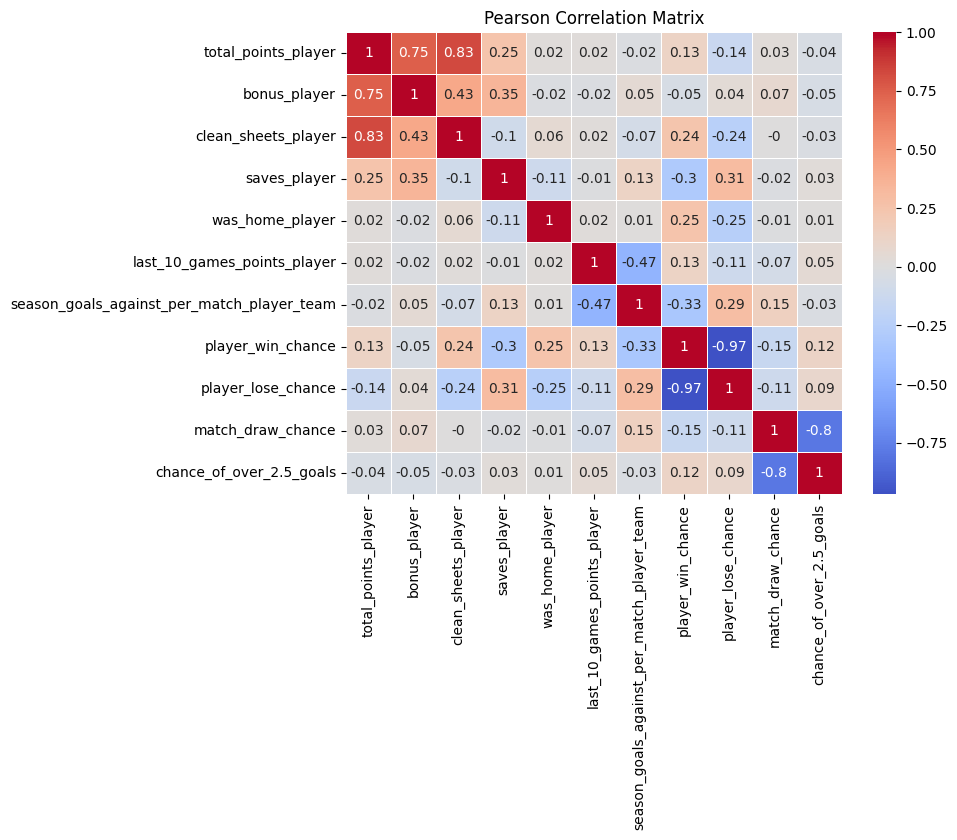

In [125]:
corr_matrix = data.corr(numeric_only=True).round(2)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Pearson Correlation Matrix")
plt.show()

We can see above that there is no correlation between odds of goals and a players points unlike expected (i.e. you would perhaps expect increase odds of over 2.5 goals meaning an increased chance of a clean sheet or total player points).

There is little to no correlation to the odds of a team winning and the number of points a player scores. We shall plot this.

There is a very strong correlation between clean sheets and total points suggesting the majority of a goalkeeper's points come from a clean sheet. Therefore a classification on this binary attribute could be suitable.

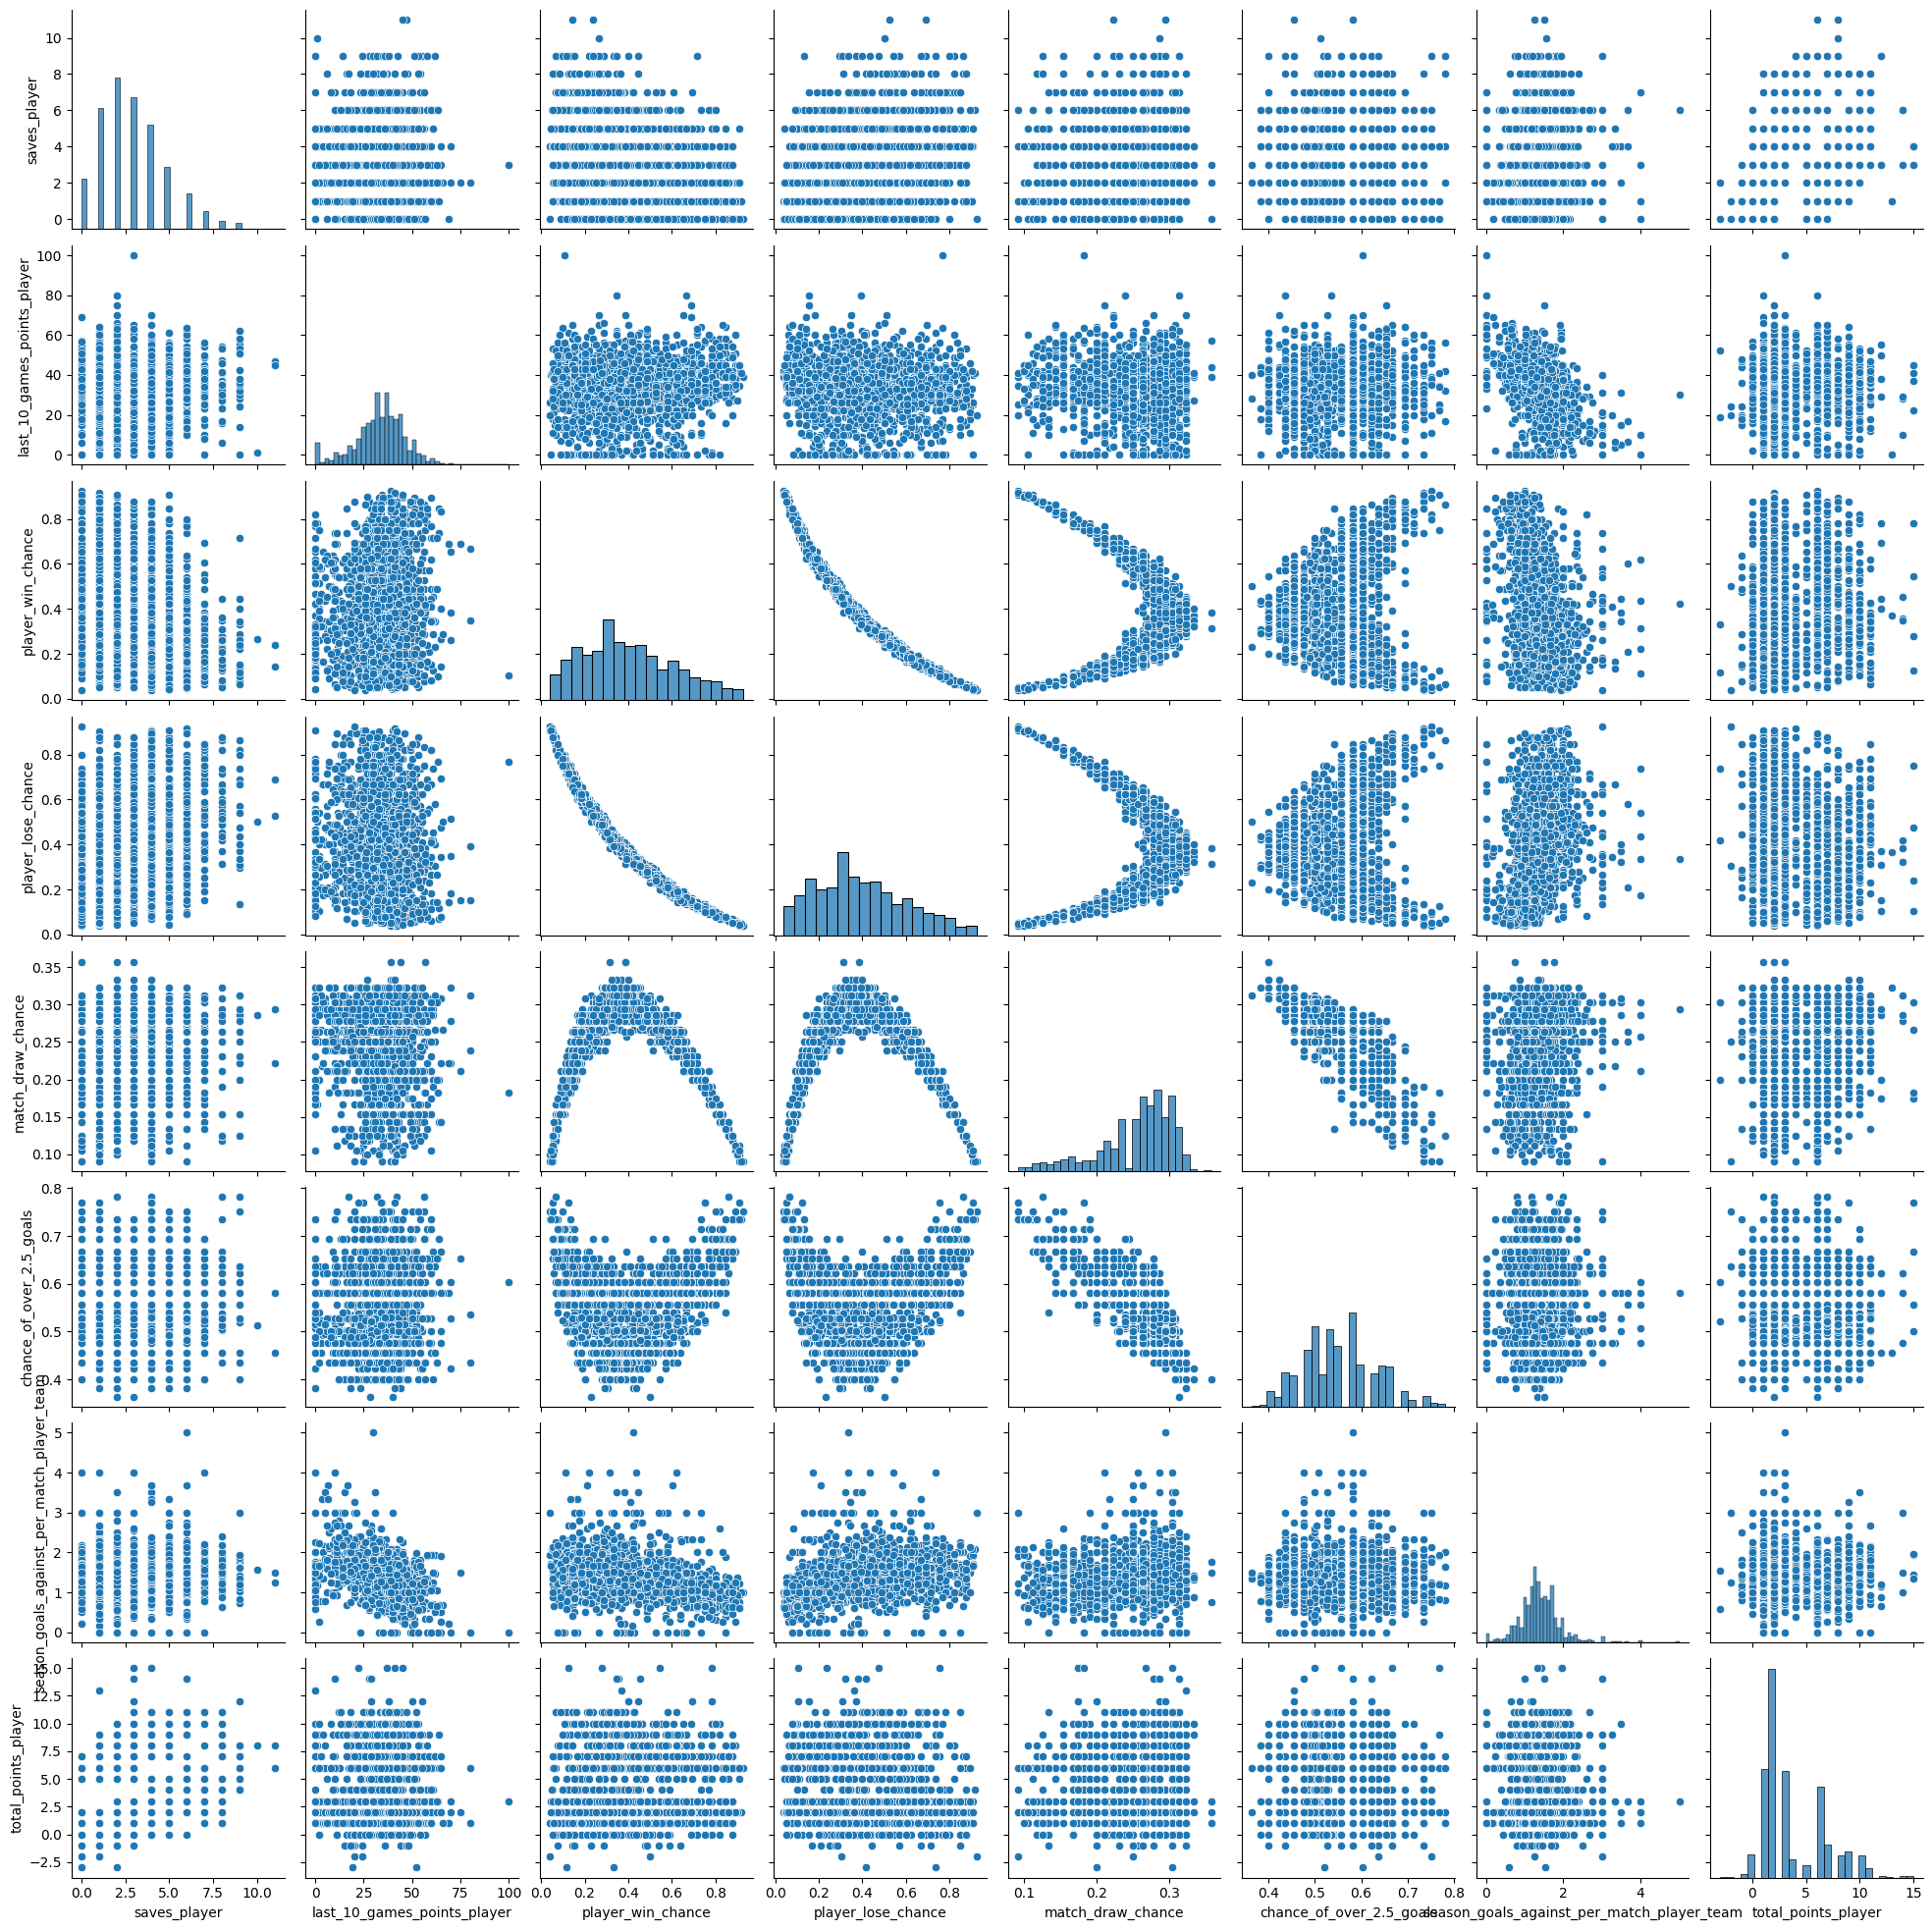

In [128]:
pairplot_columns = ["saves_player",
                   "last_10_games_points_player",
                      "player_win_chance", 
                    "player_lose_chance",
              "match_draw_chance",
              "chance_of_over_2.5_goals",
                   "season_goals_against_per_match_player_team",
                    "total_points_player",
]
sns.pairplot(data[pairplot_columns])

In [95]:
fig = px.scatter(data, x='player_win_chance', y='total_points_player', trendline = 'ols', title='How Team Win Odds Affect Player Points')
fig.show()

In [96]:
fig = px.scatter(data, x='chance_of_over_2.5_goals', y='total_points_player', trendline = 'ols', title='How Team Win Odds Affect Player Points')
fig.show()

In [103]:
fig = px.scatter(data, x='player_win_chance', y='saves_player', hover_data = ['total_points_player','name_player'], trendline = 'ols', title='How Team Win Odds Affect Player Points')
fig.show()

From the above we can see:
- Intuitively, the higher the chance of a player's team winning, the less saves they make. Approximately for every 10% their chance of winning increases, they make 0.27 less saves.
- The probability of there being over 2.5 goals has little to no impact.
- An increase in chances of a team winning by 10% causes a goalkeeper to score on average 0.18 more points. Therefore if a team was 50% more likely to win, it would only increase a player's score by 1 point.

We saw previously in the correlation plot that the main reason a goalkeeper will score points is because of a clean sheet.  While they can sometimes score big from a penatly save (intuitively the chance of this increases when they play a better team with the probability of conceededing a penalty being greater), can sometimes can gain additional points from saves, these are often down to 'luck'. 

Therefore a suitable method to forecast a goalkeeper's points seems to be:

2 + (P(clean sheet)x 4) - (0.5 x E(goals conceded)) + (E(saves) / 3) =  Expected Points

Note:
- The '4' comes from the number of points a goalkeeper scores 
- -0.5 x E(goals conceded) as a player loses a point for every 2 goals conceded.
- E(saves)/3 as a goalkeeper scores a point for every 3 saves.
- 2 for the appearance points as goalkeepers are rarely subbed.

A potential way to get this would be to look at like odds and add these to the above equation, however we'll first look at using a logistic regression process to calculate probability of a clean sheet.

In [110]:
data.shape

(1913, 14)

In [109]:
data['clean_sheets_player'].mean()

0.2885520125457397

In [107]:
data.groupby('clean_sheets_player').mean(numeric_only=True)

,total_points_player,bonus_player,saves_player,was_home_player,last_5_games_points_player,season_goals_against_per_match_player_team,player_win_chance,player_lose_chance,match_draw_chance,chance_of_over_2.5_goals
clean_sheets_player,,,,,,,,,,
0,2.169728,0.096988,3.047024,0.484938,16.973794,1.410897,0.371605,0.427632,0.254903,0.552415
1,7.425725,0.851449,2.639493,0.554348,17.154589,1.327992,0.480890,0.318890,0.254481,0.547545


Rather than predicting the chance of a team getting a clean sheet, perhaps a more accurate way to predict clean sheets would be to calculate the poisson distribution of the opponents scoring 0/1/2 goals etc.  We can then take the probability of the opponent scoring 0 goals as the chance of a team getting a clean sheet. We can continue to use this with calculating attacking player xP. If the team is expected to score 2 goals for example and Erling Haaland scores 50% of goals for Manchester City, then his expected points from goals would be 4 (4 points per goal). 